Saved giant plot to giant_combined_session_plot.png


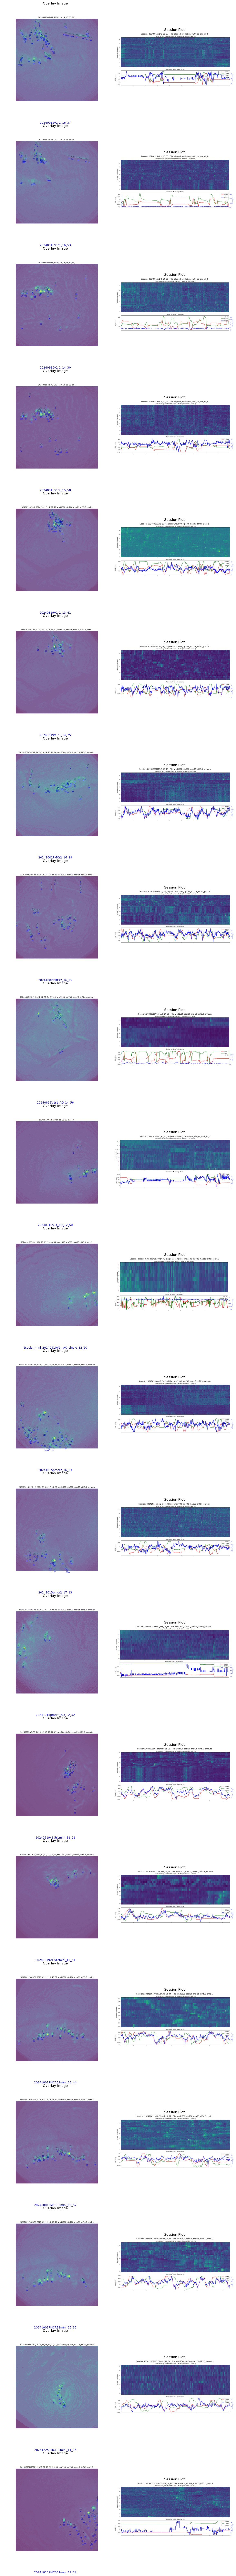

In [16]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def get_image_by_prefix(directory, prefix):
    """
    Return the first file in directory that starts with prefix and has a .png extension.
    If there are more than one, print a warning.
    
    Args:
        directory (str): Directory path where to search.
        prefix (str): File name prefix to look for.
        
    Returns:
        selected_file (str or None): The selected file path, or None if none found.
        file_list (list): List of all matching files.
    """
    pattern = os.path.join(directory, f"{prefix}*.png")
    files = glob.glob(pattern)
    
    if not files:
        return None, []
    if len(files) > 1:
        print(f"Warning: Found multiple files starting with '{prefix}' in {directory} Files: {files}")
    return files[0], files

def plot_combined_session_images_from_csv(csv_file,
                                            include_filter=None,
                                            exclude_filter=None,
                                            output_file='giant_plot.png'):
    """
    Reads session paths from a CSV file (with a column named 'path'), then for each session:
      - Navigates to its 'MIR_Aligned' subdirectory.
      - Searches for an overlay image (filename starting with 'overlay') 
        and a session plot image (filename starting with 'session_plot').
      - If multiple overlay images are found, the code attempts to disambiguate by locating
        the corresponding predictions file (with a .h5 or .nc extension) whose name contains a signature.
        That signature (everything after the last 'F_' in the predictions file) is used to select 
        the correct overlay.
      - If both images are successfully loaded, they are saved for later plotting.
    
    Finally, plots each valid session pair on a separate row and saves the resulting figure.
    """
    
    # Load session paths from the CSV file.
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Error reading CSV file {csv_file}: {e}")
        return
    
    if 'path' not in df.columns:
        print("CSV does not contain a 'path' column.")
        return
    
    session_paths = df['path'].tolist()
    valid_session_pairs = []  # List of tuples: (overlay_img, session_plot_img)
    valid_session_paths = []  # For annotations
    
    for sp in session_paths:
        # Apply include filtering: all keywords in include_filter must be in the path.
        if include_filter and not all(keyword in sp for keyword in include_filter):
            continue
        
        # Apply exclude filtering: if any keyword in exclude_filter is found in the path, skip.
        if exclude_filter and any(keyword in sp for keyword in exclude_filter):
            continue
        
        # Construct the directory path where images are stored.
        align_dir = os.path.join(sp, "MIR_Aligned")
        if not os.path.exists(align_dir):
            print(f"Directory not found: {align_dir} Skipping session: {sp}")
            continue

        # Get overlay image(s) (files starting with "overlay").
        overlay_file, overlays = get_image_by_prefix(align_dir, "overlay")
        
        # If there are multiple overlays, try to disambiguate using the predictions file.
        if overlays and len(overlays) > 1:
            # Search for predictions files with .h5 or .nc extension.
            preds = glob.glob(os.path.join(align_dir, "aligned_predictions*.[hH]5")) + \
                    glob.glob(os.path.join(align_dir, "aligned_predictions*.[nN]c"))
            if preds:
                # If there are multiple prediction files, try to use the one that does not contain 'default'
                if len(preds) > 1:
                    non_default = [p for p in preds if "default" not in p.lower()]
                    predictions_file = non_default[0] if non_default else preds[0]
                else:
                    predictions_file = preds[0]
                basename = os.path.basename(predictions_file)
                
                # Use rsplit to correctly extract the signature (text after the last "F_" until the extension).
                if "F_" in basename:
                    signature = basename.rsplit("F_", 1)[1].rsplit('.', 1)[0]
                    candidate = None
                    # Iterate through overlay candidates and select the one with an exact signature match.
                    for f in overlays:
                        base_overlay = os.path.basename(f)
                        if base_overlay.startswith("overlay_") and base_overlay.endswith(".png"):
                            candidate_sig = base_overlay[len("overlay_"):-len(".png")]
                            if candidate_sig == signature:
                                candidate = f
                                break
                    if candidate:
                        overlay_file = candidate
                    else:
                        print(f"Warning: No overlay file exactly matches the signature '{signature}' from predictions file '{basename}'. Using the first overlay candidate.")
                else:
                    print(f"Warning: Predictions file '{basename}' does not contain expected 'F_' marker. Using the first overlay candidate.")
        
        # Get session plot image (file name starting with "session_plot").
        session_plot_file, session_plots = get_image_by_prefix(align_dir, "session_plot")
        
        if overlay_file and session_plot_file:
            try:
                overlay_img = Image.open(overlay_file)
                session_plot_img = Image.open(session_plot_file)
            except Exception as e:
                print(f"Error loading images in {align_dir}: {e} Skipping session: {sp}")
                continue
            
            valid_session_pairs.append((overlay_img, session_plot_img))
            valid_session_paths.append(sp)
        else:
            found_overlay = overlays if overlays else "None"
            found_session = session_plots if session_plots else "None"
            print(f"Required images not found in {align_dir}. Found overlay: {found_overlay}, session plot: {found_session}")
    
    if not valid_session_pairs:
        print("No valid session pairs were found. Nothing to plot.")
        return

    # Create the composite figure, one row per session pair.
    n_rows = len(valid_session_pairs)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 6 * n_rows))
    
    # When there is only one row, ensure axes is a nested list.
    if n_rows == 1:
        axes = [axes]
    
    for i, ((overlay_img, session_plot_img), sp) in enumerate(zip(valid_session_pairs, valid_session_paths)):
        # Left subplot: Overlay image.
        axes[i][0].imshow(overlay_img)
        axes[i][0].axis('off')
        axes[i][0].set_title("Overlay Image")
        
        # Right subplot: Session plot image.
        axes[i][1].imshow(session_plot_img)
        axes[i][1].axis('off')
        axes[i][1].set_title("Session Plot")
        
        # Annotate each row with the session folder name.
        session_label = os.path.basename(os.path.normpath(sp))
        axes[i][0].annotate(session_label, xy=(0.5, -0.1), xycoords='axes fraction',
                            ha='center', fontsize=10, color='blue')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    print(f"Saved giant plot to {output_file}")
    plt.show()

# EXAMPLE USAGE
if __name__ == '__main__':
    csv_file = "/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/250331_sum_aligned_good_path.csv"
    
    # Set include and exclude keywords if needed.
    include_keys = []  # e.g., ["v1"]
    exclude_keys = []
    
    plot_combined_session_images_from_csv(csv_file,
                                            include_filter=include_keys,
                                            exclude_filter=exclude_keys,
                                            output_file='giant_combined_session_plot.png')
